# Demo_CCGPMA_GCE
### This demo shows an example of Multi-class classification with multiple annotators by using our model based on chained Gaussian processes for multiple annotators (GGPMA) with a loss fuction based on the Generalized Cross Entropy.

In [15]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [16]:
!pip install gpflow
!pip install tensorflow-probability[tf]==0.24.0

In [17]:
import sys
from functools import partial
import warnings
import os
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.metrics.cluster import normalized_mutual_info_score


from functools import reduce

import tensorflow as tf
import gpflow as gpf
import matplotlib.pyplot as plt

from importlib import reload
import random
random.seed(100)

from gpflow.ci_utils import reduce_in_tests
from gpflow.utilities import print_summary
from gpflow.quadrature import hermgauss
from gpflow.quadrature.deprecated import mvnquad, ndiagquad, ndiag_mc

gpf.config.set_default_float(np.float64)
gpf.config.set_default_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline
from check_shapes import check_shapes, inherit_check_shapes

MAXITER = reduce_in_tests(2000)

In [18]:
# Clone the repo containig useful functions and the model
!git clone https://github.com/juliangilg/CCGPGCE.git
sys.path.append('/content/CCGPGCE')

fatal: destination path 'CCGPGCE' already exists and is not an empty directory.


In [19]:
# Loading useful funtions
from utils import *
from ccgpgce import multiClassMA_GCE

## 1. Multi-class classification problem definition

We assume a 1D multi-class classification problem, where input features are given as $x \in [0, 1]$ and the outputs are generated as follows

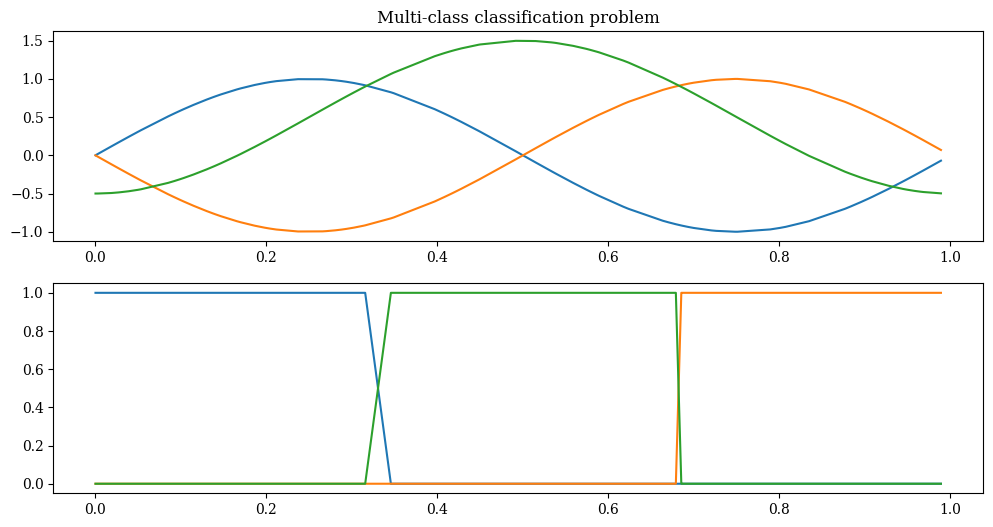

In [20]:
N = 100

np.random.seed(1)
X = np.random.rand(N,1)

t1 = (np.sin(2*np.pi*X)).reshape(N,1)
t2 = (-np.sin(2*np.pi*X)).reshape(N,1)
t3 = (-np.sin(2*np.pi*(X+0.25))+0.5).reshape(N,1)
t = np.concatenate((t1, t2, t3), axis=1)

idx = np.argsort(X, axis=0).flatten()
X = X[idx]
t = t[idx,:]
y = np.array(np.argmax(t, 1).reshape(-1,1), dtype=float)+1
K = len(np.unique(y))

# The true labels in codification 1-of-K
Yhat = one_of_K(y, K)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(X, t)
plt.title('Multi-class classification problem')
plt.subplot(2,1,2)
plt.plot(X, Yhat)
plt.show()

To define the training set, we randomly obtain $N=100$ samples from the interval $[0, 1]$. Conversely, for the test set, we sample uniformly $200$ points from $[0, 1]$

In [21]:
seed = 1
np.random.seed(seed)
Ntest = 200

# The training set
Xtrain = X
Xtrain = Xtrain.reshape((N,1))
ytrain = y

# The test set
Xtest = np.linspace(0, 1, Ntest).reshape((Ntest,1))
t1 = (np.sin(2*np.pi*Xtest)).reshape(Ntest,1)
t2 = (-np.sin(2*np.pi*Xtest)).reshape(Ntest,1)
t3 = (-np.sin(2*np.pi*(Xtest+0.25))+0.5).reshape(Ntest,1)
ttest = np.concatenate((t1, t2, t3), axis=1)
ytest = np.array(np.argmax(ttest, 1).reshape(-1,1), dtype=float)+1

## 2. Multiple annotators simulation


First, we define the some parameters related to the labelers

In [22]:
R = 5 # Number of annotators
NrP = 1.0 # the percentage of samples labeled by each annotator

Z_r, Ytrain, iAnn, Vref = multiple_annotators(R, NrP, Xtrain, ytrain)

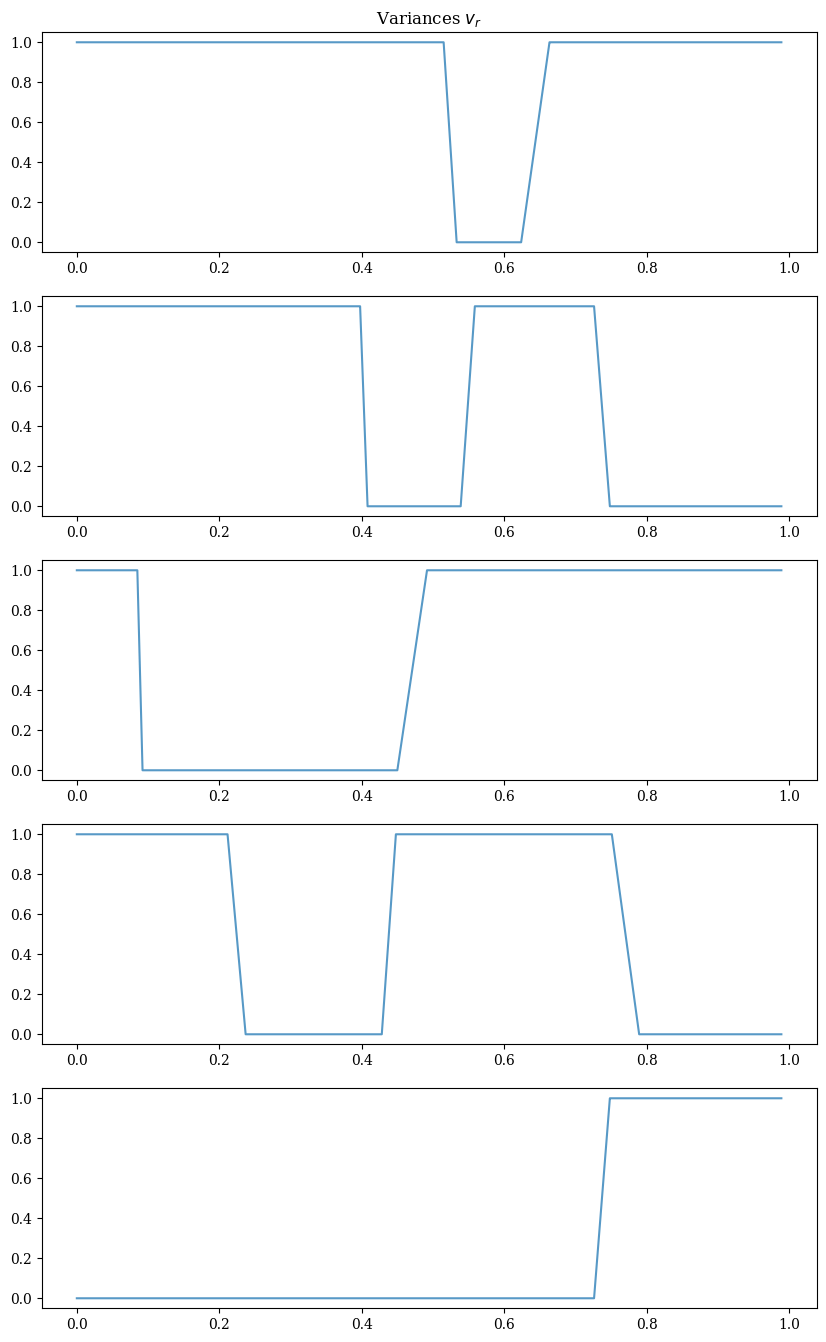

In [23]:
# We plot the annotators reliability as a function of the input features

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.figure(figsize=(10, 20))
for r in range(R):
    #Plots
    plt.subplot(6,1,r+1)
    plt.plot(Xtrain, Z_r[r], alpha=0.75, label='$v_'+str(r+1)+'$')
plt.subplot(6,1,1)
plt.title(r'Variances $v_r$')
plt.show()

In [24]:
#annotators performance
Acc = np.zeros((R+1,1))
for r in range(R):
    Acc[r,:] = accuracy_score(ytrain, Ytrain[:,r])
Acc[-1,:] = accuracy_score(ytrain, MAjVot(Ytrain, K))
NameCol = ['Accuracy']
NameIdx = ['Annotator_1','Annotator_2','Annotator_3','Annotator_4','Annotator_5','MajorityVoting']
Per = pd.DataFrame(Acc, columns =NameCol, index=NameIdx)
Per

,Accuracy
Annotator_1,0.88
Annotator_2,0.61
Annotator_3,0.59
Annotator_4,0.58
Annotator_5,0.24
MajorityVoting,0.80


## 4. Correlated Chained Gaussian processes for multiple annotators (CCGPMA) using a Generalized cross-entropy function as a log P


We need to create a new likelihood function. We should define a class with at least three methods:
1. _log_prob
2. _variational_expectations
3. _predict_mean_and_var


### 1. *_log_prob*. For multiclass classification we use a Categorical likelihood.

$$p\left(\mathbf{Y}|\mathbf{f}^{(1)}, \dots , \mathbf{f}^{(K)}, \mathbf{f}^{(K+1)}, \dots , \mathbf{f}^{(K+R)}\right) = \prod_{i=1}^N\prod_{r=1}^R\left(\prod_{k=1}^K (\zeta_{ik})^{\delta(y_i^{(r)}, k)}\right)^{z_{i}^{(r)}}\left(\frac{1}{K}\right)^{1-z_{i}^{(r)}},$$

where $$\zeta_{ik} = \operatorname{softmax}\left(f_i^{(1)}, f_i^{(2)}, \dots ,f_i^{(K)}\right) = \frac{\exp({f_i}^{(k)})}{\sum_{l=1}^K\exp({f_i^{(l)}})},$$ $f_i^{(k)}$ is the output of the $k$-th Gaussian proces for sample $\mathbf{x}_i$. Besides,

$$\delta(y_i^{(r)}, k) = \begin{cases} 1, & y_i^{(r)}=k\\
0, & \mbox{otherwise} \end{cases}.$$

On the other hand,

$$z_{i}^{(r)} = \sigma(f_i^{(K+r)})$$

 Hence,

$$\begin{align} \log p\left(\mathbf{Y}|\mathbf{f}^{(1)}, \dots , \mathbf{f}^{(K)}, \mathbf{f}^{(K+1)}, \dots , \mathbf{f}^{(K+R)}\right) &= \sum_{i=1}^N\sum_{r=1}^R z_{i}^{(r)}\underbrace{\left(\sum_{k=1}^K\delta(y_i^{(r)}, k)\log(\zeta_{ik})\right)}_{\mbox{Cross-entropy}} + \left(1 - z_{i}^{(r)}\right)\log\left(\frac{1}{K}\right).
\end{align}$$

We change the cross entropy function for a generalized cross entropy functions, which is more robust under the presence of noise labels. In that sense,

$$\log p\left(\mathbf{Y}|\mathbf{f}^{(1)}, \dots , \mathbf{f}^{(K)}, \mathbf{f}^{(K+1)}, \dots , \mathbf{f}^{(K+R)}\right) = \frac{1}{\beta}\sum_{i=1}^N\sum_{r=1}^R z_{i}^{(r)}\left(-\sum_{k=1}^K\delta(y_i^{(r)}, k)\left(1 - \zeta_{ik}^{\beta}\right)\right) - \left(1 - z_{i}^{(r)}\right)\left(1 - \frac{1}{K^{\beta}}\right).$$

### 2. *_variational_expectations*. Now we need to compute the expectations of the log likelihood w.r.t. the variational posterior distributions $q(\mathbf{f}^{(1)}), \dots ,q(\mathbf{f}^{(K)}),q(\mathbf{f}^{(K+1)}),\dots , q(\mathbf{f}^{(K+R)})$, where each distribution follows a multivariate Gaussian distribution with mean $F_{mu}$ and a given covariance; however, since we assume independence in the likelihood function, we don't need the covariance but the variance $F_{var}$.

$$\begin{align}\mathbb{E}_{q(\mathbf{f}^{(1)}), \dots ,q(\mathbf{f}^{(K)}),q(\mathbf{f}^{(K+1)}),\dots , q(\mathbf{f}^{(K+R)})}[\log p(\mathbf{Y}|\mathbf{f})] &= \mathbb{E}_{q(\mathbf{f}^{(1)}), \dots ,q(\mathbf{f}^{(K)}),q(\mathbf{f}^{(K+1)}),\dots , q(\mathbf{f}^{(K+R)})}\left[\frac{1}{\beta}\sum_{i=1}^N\sum_{r=1}^R z_{i}^{(r)}\left(-\sum_{k=1}^K\delta(y_i^{(r)}, k)\left(1 - \zeta_{ik}^{\beta}\right)\right) - \left(1 - z_{i}^{(r)}\right)\left(1 - \frac{1}{K^{\beta}}\right)\right]\\
&= \frac{1}{\beta}\sum_{i=1}^N\sum_{r=1}^R \mathbb{E}_{q(\mathbf{f}^{(K+r)})}\left[z_{i}^{(r)}\right]\left(-\sum_{k=1}^K\delta(y_i^{(r)}, k)\mathbb{E}_{q(\mathbf{f^{(1)}}), \dots ,q(\mathbf{f^{(K)}})}\left[\left(1 - \zeta_{ik}^{q}\right)\right]\right) - \left(1 - \mathbb{E}_{q(\mathbf{f}^{(K+r)})}\left[z_{i}^{(r)}\right]\right)\left(1 - \frac{1}{K^{\beta}}\right)\end{align},$$

where
$$\mathbb{E}_{q(\mathbf{f^{(1)}}), \dots ,q(\mathbf{f^{(K)}})}\left[\left(1 - \zeta_{ik}^{q}\right)\right] = \int \dots \int
\left(1 - \zeta_{ik}^{\beta}\right)q(\mathbf{f^{(1)}}), \dots ,q(\mathbf{f^{(K)}}) d\mathbf{f^{(K+r)}}, \dots ,d\mathbf{f^{(K)}}.$$
$$\mathbb{E}_{q(\mathbf{f^{(1)}})}\left[z_{i}^{(r)}\right] = \int
z_{i}^{(r)}q(\mathbf{f^{(K+r)}})d\mathbf{f^{(K+r)}}.$$

The above integral has not anlytical solution; thus, we resort to a numerical approximation, especifically, we use MonteCarlo sampling.

### 3. *_predict_mean_and_var*. Finally, we need to define the mean and variance of prediction distribution for a new sample $\mathbf{x}_{*}$.

- Predictive distributions for the classification function

$$\operatorname{mean} = \mathbb{E}\left[\operatorname{softmax}\left(f_{*}^{(1)}, \dots ,f_{*}^{(K)}\right)\right] = \int\dots\int \operatorname{softmax}\left(f_{*}^{(1)}, \dots ,f_{*}^{(K)}\right)q(f_{*}^{(1)})\dots q(f_{*}^{(K)})df_{*}^{1}\dots df_{*}^{K}.$$

Similarly, $\operatorname{var} = \mathbb{E}\left[\operatorname{softmax}\left(f_{*}^{(1)}, \dots ,f_{*}^{(K)}\right)^2\right] - \mathbb{E}\left[\operatorname{softmax}\left(f_{*}^{(1)}, \dots ,f_{*}^{(K)}\right)\right]^2$, where

$$\mathbb{E}\left[\operatorname{softmax}\left(f_{*}^{(1)}, \dots ,f_{*}^{(K)}\right)^2\right] = \int\dots\int \operatorname{softmax}\left(f_{*}^{(1)}, \dots ,f_{*}^{(K)}\right)^2q(f_{*}^{(1)})\dots q(f_{*}^{(K)})df_{*}^{1}\dots df_{*}^{K}.$$

- Predictive distributions for the annotators performance

$$\operatorname{mean} = \mathbb{E}\left[\sigma\left(f_{*}^{(K+r)}\right)\right] = \int \sigma\left(f_{*}^{(K+r)}\right)q(f_{*}^{(K+r)})df_{*}^{(K+r)}.$$

Similarly, $\operatorname{var} = \mathbb{E}\left[\sigma\left(f_{*}^{(K+r)}\right)^2\right]  - \mathbb{E}\left[\sigma\left(f_{*}^{(K+r)}\right)\right] ^2$, where

$$\mathbb{E}\left[\sigma\left(f_{*}^{(K+r)}\right)^2\right]  = \int \sigma\left(f_{*}^{(K+r)}\right)^2(qf_{*}^{(K+r)})df_{*}^{(K+r)}.$$

In [25]:
# GP definition

# KERNELS
L = R+K  # number of latent functions
M = 10  # number of inducing points
minibatch_size = 100

# # INDUCING POINTS
minX = Xtrain.min()
maxX = Xtrain.max()
Zinit = np.linspace(0, 1, M)
Zinit = Zinit[:, np.newaxis]

# Create list of kernels for each output
kern_list = [
    gpf.kernels.SquaredExponential(variance=0.5, lengthscales=0.01) for _ in range(L)
]
# Create multi-output kernel from kernel list
kernel = gpf.kernels.LinearCoregionalization(
    kern_list, W= np.identity(L)
)  # Notice that we initialise the mixing matrix W
# initialisation of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)


# initialize mean of variational posterior to be of shape MxL
q_mu = np.zeros((M, L))
# initialize \sqrt(Σ) of variational posterior to be of shape LxMxM
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 0.1

# create SVGP model as usual and optimize
m = gpf.models.SVGP(
    kernel,
    multiClassMA_GCE(K, R, 0.1),
    inducing_variable=iv,
    q_mu=q_mu,
    q_sqrt=q_sqrt,
)

Text(0, 0.5, 'ELBO')

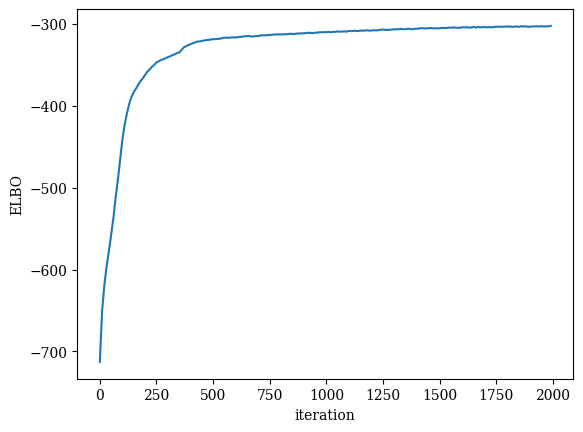

In [26]:
# Model Training and ELBO plot
N = Xtrain.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices((Xtrain, Ytrain)).repeat()
lr=0.01
logf = run_adam(m, train_dataset, minibatch_size, MAXITER, lr)
plt.plot(np.arange(MAXITER)[::10], logf)
plt.xlabel("iteration")
plt.ylabel("ELBO")

In [27]:
pY, pYv = m.predict_y(Xtest)

## 5. Figures  and Perfomance assessment

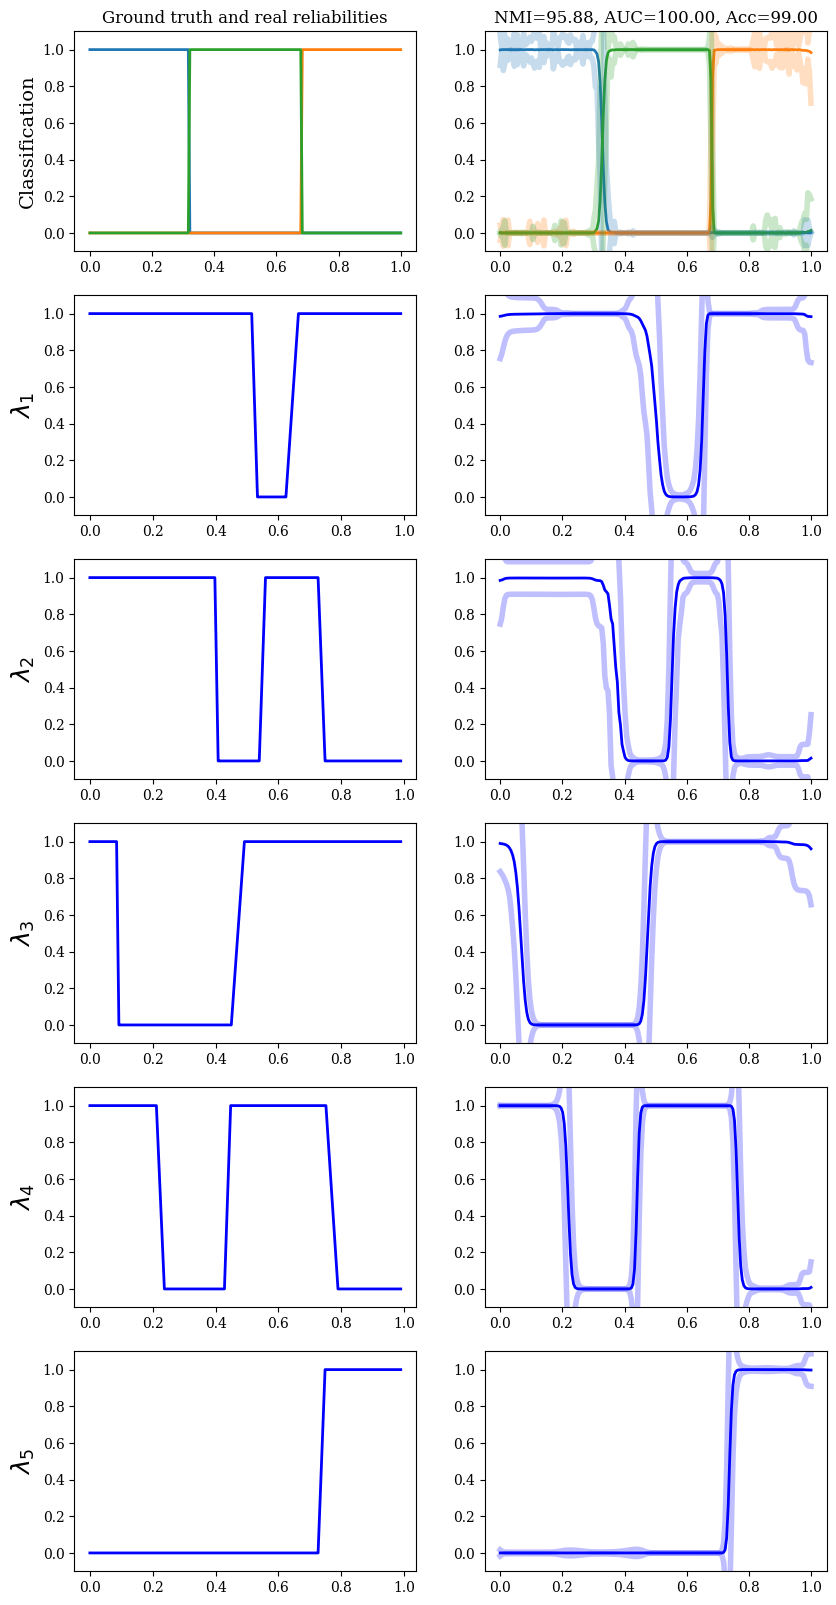

In [28]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.figure(figsize=(15, 20))

Mc, Vc = pY.numpy(), abs(pYv.numpy())
M, V = pY.numpy(), abs(pYv.numpy())
Yhat_test = one_of_K(ytest, K)

for r in range(R+1):
    # Original Values
    miny = 0
    maxy = 1
    if r ==0:
        plt.subplot(R+1,3, 3*r+1)
        plt.plot(Xtest, Yhat_test, linewidth=2, alpha=1)
        plt.ylabel("Classification",fontsize=14)
        plt.ylim(miny-0.1, maxy+0.1)
    else:
        plt.subplot(R+1,3, 3*r+1)
        plt.plot(Xtrain, Z_r[r-1], 'b-', linewidth=2, alpha=1)
        plt.ylabel(r"$"+r"\lambda_"+str(r)+'$', fontsize=18)
        plt.ylim(-0.1, 1.1)

    # CGP
    if r > 0:
        mfc, vfc = Mc[:, K+r-1], Vc[:, K+r-1]
        mf_upperc = mfc + 2*np.sqrt(vfc)
        mf_lowerc = mfc - 2*np.sqrt(vfc)

        plt.subplot(R+1,3, 3*r+2)
        plt.plot(Xtest, (mfc), 'b-', linewidth=2, alpha=1)
        plt.plot(Xtest, (mf_upperc), 'b-', linewidth=4, alpha=0.25)
        plt.plot(Xtest, (mf_lowerc), 'b-', linewidth=4, alpha=0.25)
        plt.ylim(-0.1, 1.1)
    else:
        mfc, vfc = Mc[:, :K], Vc[:, :K]
        mf_upperc = mfc + 2*np.sqrt(vfc)
        mf_lowerc = mfc - 2*np.sqrt(vfc)

        plt.subplot(R+1,3, 3*r+2)
        plt.plot(Xtest, (mfc), linewidth=2, alpha=1)
        plt.gca().set_prop_cycle(None)
        plt.plot(Xtest, (mf_upperc), linewidth=4, alpha=0.25)
        plt.gca().set_prop_cycle(None)
        plt.plot(Xtest, (mf_lowerc), linewidth=4, alpha=0.25)
        plt.ylim(miny-0.1, maxy+0.1)




# Classification performance
auxM = np.array(np.argmax(M[:,:K], 1).reshape(-1,1), dtype=float)+1


AccCCGP  = accuracy_score(ytest, auxM)
AUC_CCGP = roc_auc_score(Yhat_test, M[:,:K])
NMI_CCGP = normalized_mutual_info_score(ytest.flatten(), auxM.flatten())

plt.subplot(R+1,3,1)
plt.title('Ground truth and real reliabilities')
plt.subplot(R+1,3,2)
plt.title('NMI='+"{:.2f}".format(NMI_CCGP*100)+', AUC='+"{:.2f}".format(AUC_CCGP*100)+', Acc='"{:.2f}".format(AccCCGP*100))
plt.show()
